In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

In [3]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# File loading
### read hopital names from datasets ###
df = pd.read_csv(r'./datasets/hospital_augment_train3.csv')

In [5]:
hospital_gen_train = list(df['gen_data'].iloc[:10000])
hospital_true_train = list(df['true_data'].iloc[:10000])

In [6]:
df_val = pd.read_csv(r'./datasets/hospital_augment_val3.csv')
df_test = pd.read_csv(r'./datasets/hospital_augment_test3.csv')

In [7]:
hospital_gen_val = list(df_val['gen_data'])
hospital_true_val = list(df_val['true_data'])
hospital_gen_test = list(df_test['gen_data'])
hospital_true_test = list(df_test['true_data'])

In [8]:
len(hospital_gen_train)

10000

In [9]:
# Preprocessing
import re
def process(sent):
    sent=sent.lower()
    sent=re.sub(r'[^0-9a-zA-Z ]','',sent)
    sent=sent.replace('\n','')
    return sent 

In [10]:
from pythainlp import thai_letters

In [11]:
label_map_0 = ["0","1","2","3","4","5","6","7","8","9","-",".","/","(",")","\"","&"]
label_map_1 = list(thai_letters)

In [12]:
char_set = label_map_0+label_map_1

In [13]:
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

In [14]:
count = len(char_set)
codes = ['\t' ,'\n', ' ']

In [15]:
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1

In [16]:
input_texts = []
target_texts = []

In [17]:
hospital_true_train[0]

'คลินิกกรุงเทพระยองสาขาบ่อวิน'

In [18]:
for i,line in enumerate(hospital_true_train):
    output_text = '\t' + line + '\n'
    input_texts.append(hospital_gen_train[i])
    target_texts.append(output_text)
print("LEN OF SAMPLES:",len(input_texts))

LEN OF SAMPLES: 10000


In [19]:
input_texts[0],target_texts[0]

('คลินิกกรุงเทพระยองาขาบ่อวิน', '\tคลินิกกรุงเทพระยองสาขาบ่อวิน\n')

In [20]:
max_enc_len = max([len(x)+x.count(' ') for x in input_texts])
max_dec_len = max([len(x)+x.count(' ') for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 74
Max Dec Len: 75


In [21]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)+3),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [22]:
encoder_input_data.shape,decoder_input_data.shape,decoder_target_data.shape

((10000, 74, 93), (10000, 75, 93), (10000, 75, 93))

In [23]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")         

COMPLETED...


In [24]:
len(input_texts),len(target_texts)

(10000, 10000)

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense,Activation,Attention,Bidirectional,Concatenate
import tensorflow as tf

In [26]:
batch_size = 128
epochs = 100
latent_dim = 128

num_enc_tokens = len(char_set)+3
num_dec_tokens = len(char_set) + 3 # includes \n \t ' '
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = Bidirectional(LSTM(latent_dim,return_state=True))
#encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
#encoder_outputs , state_h, state_c = encoder(encoder_inputs)
#encoder_states = [state_h,state_c]
#encoder_states = [ forward_h, forward_c, backward_h, backward_c]
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

In [33]:
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim*2,return_sequences=True,return_state=True)#
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

In [28]:
num_dec_tokens

93

In [29]:
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

In [30]:
val_x = []
val_y = []
for i,line in enumerate(hospital_true_val):
    output_text = '\t' + line + '\n'
    val_x.append(hospital_gen_val[i])
    val_y.append(output_text)
print("LEN OF SAMPLES:",len(val_x))

LEN OF SAMPLES: 3353


In [31]:
max_enc_len_val = max([len(x)+x.count(' ') for x in val_x])
max_dec_len_val = max([len(x)+x.count(' ') for x in val_y])
print("Max Enc Len:",max_enc_len_val)
print("Max Dec Len:",max_dec_len_val)

Max Enc Len: 73
Max Dec Len: 75


In [32]:
##### Validation Set #####
num_samples_val = len(val_x)
encoder_input_data_val = np.zeros( (num_samples_val , max_enc_len_val , len(char_set)+3),dtype='float32' )
decoder_input_data_val = np.zeros( (num_samples_val , max_dec_len_val , len(char_set)+3),dtype='float32' )
decoder_target_data_val = np.zeros( (num_samples_val , max_dec_len_val , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [33]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(val_x,val_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_val[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_val[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_val[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")     

COMPLETED...


In [35]:
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
#model = Model.add(Attention())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 227328      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]        

In [36]:
### Model includes only true sequence ###
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=50)

saveModel_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath= "models/bilstm_hosipital_gendata_v2",
            save_best_only=True,
            monitor='accuracy',
            save_weights_only = True,
            verbose=1)
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

In [37]:
hist=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = 200,
          batch_size = batch_size)

000/10000 [==============================] - 7s 711us/sample - loss: 0.1256 - accuracy: 0.2521
Epoch 23/200
10000/10000 [==============================] - 4s 377us/sample - loss: 0.1161 - accuracy: 0.2548
Epoch 24/200
10000/10000 [==============================] - 3s 346us/sample - loss: 0.1086 - accuracy: 0.2569
Epoch 25/200
10000/10000 [==============================] - 3s 349us/sample - loss: 0.1010 - accuracy: 0.2591
Epoch 26/200
10000/10000 [==============================] - 3s 347us/sample - loss: 0.0949 - accuracy: 0.2612
Epoch 27/200
10000/10000 [==============================] - 3s 347us/sample - loss: 0.0883 - accuracy: 0.2628
Epoch 28/200
10000/10000 [==============================] - 3s 349us/sample - loss: 0.0830 - accuracy: 0.2644
Epoch 29/200
10000/10000 [==============================] - 3s 349us/sample - loss: 0.0775 - accuracy: 0.2658
Epoch 30/200
10000/10000 [==============================] - 3s 347us/sample - loss: 0.0725 - accuracy: 0.2675
Epoch 31/200
10000/10000 

In [39]:
import matplotlib.pyplot as plt

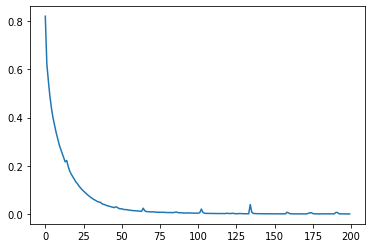

In [40]:
plt.plot(hist.history['loss'])

In [42]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder_v2.h5')
decoder_model.save('decoder_v2.h5')

In [43]:
from tensorflow.keras.models import load_model

In [44]:
encoder_model = load_model('encoder_v2.h5',compile=False)

In [45]:
decoder_model = load_model('decoder_v2.h5',compile=False)

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    decoded_list =[]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_list.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence,decoded_list

In [47]:
pred_sent = []
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

-
Wrong sentence: คลินิกกรุงเทพระยองาขาบ่อวิน
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ่อวิน

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ่อวิน

-
Wrong sentence: คลินิกกรุงเทระยองสาขาบ้านฉาง
Corrected sentence: คลินิกกรุงเทพระยองสาขาบ้านฉาง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาบ้านฉาง

-
Wrong sentence: คลินิกกรุงเทระยองสาขาปลวกแดง
Corrected sentence: คลินิกกรุงเทพระยองสาขาปลวกแดง

Ground Truth: 	คลินิกกรุงเทพระยองสาขาปลวกแดง

-
Wrong sentence: คินิกไทยอินเตอร์การแพทย์(เกาะพงัน)
Corrected sentence: คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

Ground Truth: 	คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)

-
Wrong sentence: คลินิกพญไทเวชกรรมบ่อวิน
Corrected sentence: คลินิกพญาไทเวชกรรมบ่อวิน

Ground Truth: 	คลินิกพญาไทเวชกรรมบ่อวิน

-
Wrong sentence: คลินกรวมแพทย์นิคม
Corrected sentence: คลินิกรวมแพทย์นิคม

Ground Truth: 	คลินิกรวมแพทย์นิคม

-
Wrong sentence: คลินิกรักสุขภาจ.ระยอง
Corrected sentence: คลินิกรักสุขภาพจ.ระยอง

Ground Truth: 	คลินิกรักสุขภาพจ.ระยอง

-
Wrong sentence: คลินกโรงพยาบาลกรุงเทพพัทยาสา

In [48]:
test_x = []
test_y = []
for i,line in enumerate(hospital_true_test[:200]):
    output_text = '\t' + line + '\n'
    test_x.append(hospital_gen_test[i])
    test_y.append(output_text)
print("LEN OF SAMPLES:",len(test_y))

LEN OF SAMPLES: 200


In [49]:
max_enc_len_test = max([len(x)+x.count(' ') for x in test_x])
max_dec_len_test = max([len(x)+x.count(' ') for x in test_y])
print("Max Enc Len:",max_enc_len_test)
print("Max Dec Len:",max_dec_len_test)

Max Enc Len: 52
Max Dec Len: 55


In [50]:
##### Validation Set #####
num_samples_test = len(test_x)
encoder_input_data_test = np.zeros( (num_samples_test , max_enc_len_test , len(char_set)+3),dtype='float32' )
decoder_input_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
decoder_target_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [51]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(test_x,test_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_test[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_test[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_test[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")  

COMPLETED...


In [52]:
model.evaluate([encoder_input_data_test,decoder_input_data_test],decoder_target_data_test)

200/200 [==============================] - 2s 10ms/sample - loss: 0.0158 - accuracy: 0.3785


[0.015817984621971846, 0.37854546]

In [53]:
pred_sent_test = []
for seq_index in range(num_samples_test):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_test.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

-
Wrong sentence: เซ็นทรัลเมดิคลินิกเวชกรรมสาขาดินแดง
Corrected sentence: โรงพยาบาลธัญญรักษ์แม่ฮ่องสอน

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาากเกร็ด
Corrected sentence: โรงพยาบาลนครพิงค์

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

-
Wrong sentence: เซ็นทรัลเมดิกคลนิกเวชกรรมสาขาพระโขนง
Corrected sentence: โรงพยาบาลนาคู

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

-
Wrong sentence: เเลแคร์คลินิกเจริญกรุง
Corrected sentence: โรงพยาบาลนายแพทย์หาญ

Ground Truth: 	เทเลแคร์คลินิกเจริญกรุง

-
Wrong sentence: เทเลแคร์คลินิกสหคลินิกสาาวัชรพล
Corrected sentence: โรงพยาบาลน้ำปาด

Ground Truth: 	เทเลแคร์คลินิกสหคลินิกสาขาวัชรพล

-
Wrong sentence: ธรรมุนทรคลินิกเวชกรรม
Corrected sentence: โรงพยาบาลโนนแดง

Ground Truth: 	ธรรมสุนทรคลินิกเวชกรรม

-
Wrong sentence: ธรมสุนทรคลินิกเวชกรรมสาขาคลองสาน
Corrected sentence: โรงพยาบาลบ่อพลอย

Ground Truth: 	ธรรมสุนทรคลินิกเวชก